In [1]:
from pyspark import SparkContext
import pyspark
from io import StringIO
import csv
import pandas as pd
import matplotlib.pyplot as plt
conf = pyspark.SparkConf().set("spark.driver.host", "localhost")
sc = SparkContext.getOrCreate()
sc.setLogLevel('OFF')

23/12/01 12:47:37 WARN Utils: Your hostname, Marks-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.0.0.213 instead (on interface en0)
23/12/01 12:47:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/01 12:47:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
sc.stop()

In [2]:
dataset = sc.textFile("/Users/marklam/Desktop/USF/Fall2/MSDS694-DC/Project/On_time_data/On_Time_On_Time_Performance_2005_1.csv")

In [3]:
dataset = sc.textFile("/Users/ericshen/Desktop/USFCA MASTERS STUFF/2023/Fall Two 2023/Dist Computing/On_time_data/On_Time_On_Time_Performance_2005_1.csv")

The data we are looking at comes from the department of transportation. The data was collected from 1987-present, and contains flight information with 40 plus columns including date, airlines, flight delays, airtime and much more. 

With such a large amount of data and a wide range of features we can use, there are a lot of interesting things we could look at. Given that we are also currently studying time series, it would be interesting to analyze trends over the years. Such as if/how volume of flights, popular routes, or flight durations changed over the years. We have also looked at number of flights based on weekdays/months with interesting findings. We also looked at the performance of various airports in terms of flight delays, cancellations, and overall traffic. As well as comparing different airlines based on various metrics like punctuality, cancellation rates, and flight frequencies. We also decided to use visualizations for some of these insights to help us better interpret the results we found. 

If we have enough time, we could also try to create different models to predict features such as flight delays and cancellations.

In [6]:
'''
years = range(2005,2016)
dataset_1 = sc.emptyRDD()
for year in years:
    file = f"/Users/ericshen/Desktop/USFCA MASTERS STUFF/2023/Fall Two 2023/Dist Computing/On_time_data/On_Time_On_Time_Performance_{year}_1.csv"
    rdd2 = sc.textFile(file)
    first = rdd2.first()
    dataset_1 = dataset_1.union(rdd2.filter(lambda row: row != first))
    print(dataset_1.count())
'''

'\nyears = range(2005,2016)\ndataset_1 = sc.emptyRDD()\nfor year in years:\n    file = f"/Users/ericshen/Desktop/USFCA MASTERS STUFF/2023/Fall Two 2023/Dist Computing/On_time_data/On_Time_On_Time_Performance_{year}_1.csv"\n    rdd2 = sc.textFile(file)\n    first = rdd2.first()\n    dataset_1 = dataset_1.union(rdd2.filter(lambda row: row != first))\n    print(dataset_1.count())\n'

In [6]:
df = pd.read_csv("/Users/marklam/Desktop/USF/Fall2/MSDS694-DC/Project/On_time_data/On_Time_On_Time_Performance_2005_1.csv")

In [7]:
df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,TailNum,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2005,1,1,1,6,2005-01-01,AA,19805,AA,N338AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005,1,1,2,7,2005-01-02,AA,19805,AA,N323AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005,1,1,3,1,2005-01-03,AA,19805,AA,N336AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005,1,1,4,2,2005-01-04,AA,19805,AA,N327AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005,1,1,5,3,2005-01-05,AA,19805,AA,N327AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
dataset.count()

594925

In [4]:
def parse_line(line):
    """
    Parses a line of CSV data into a list of values.
    """
    reader = csv.reader(StringIO(line))
    return next(reader)

def parse_numeric(value):
    """
    Converts a value to numeric, returns 0 if the conversion fails.
    """
    try:
        return float(value)
    except ValueError:
        return 0
    
parsed_rdd = dataset.map(parse_line)

In [5]:
subset = parsed_rdd.take(5000)
subset_rdd = sc.parallelize(subset)

In [8]:
# count the number of flights where the origin state is CA
subset_rdd.filter(lambda x: x[16] == 'CA').count()

1570

In [31]:
numeric_values = subset_rdd.map(lambda row: parse_numeric(row[32]))

valid_numeric_values = numeric_values.filter(lambda x: x is not None)

# map to (value, 1) pairs
value_count_pairs = valid_numeric_values.map(lambda x: (x, 1))

# reduce by summing both elements of the tuples
total_sum, total_count = value_count_pairs.reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]))

# calculate the average
average_delay = total_sum / total_count if total_count > 0 else 0

print(f"Average Departure Delay: {average_delay} minutes")

Average Departure Delay: 12.9574 minutes


In [32]:
numeric_values = subset_rdd.map(lambda row: parse_numeric(row[43]))

valid_numeric_values = numeric_values.filter(lambda x: x is not None)

# map to (value, 1) pairs
value_count_pairs = valid_numeric_values.map(lambda x: (x, 1))

# reduce by summing both elements of the tuples
total_sum, total_count = value_count_pairs.reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]))

# calculate the average
average_delay = total_sum / total_count if total_count > 0 else 0

print(f"Average Arrival Delay: {average_delay} minutes")

Average Arrival Delay: 16.4144 minutes


In [36]:
subset_rdd.collect()[0][25]

'DestState'

In [37]:
# count flights from New York to CA

subset_rdd.filter(
    lambda x: "New York" in x[15] and x[25] == "CA"
).count()

550

In [38]:
# count flights from New York to Los Angeles

subset_rdd.filter(lambda x: "New York" in x[15] and x[24].split(",")[0] == "Los Angeles").count()

317

In [45]:
# count the number of flights based on which day of the week

day_of_week_counts = subset_rdd.map(lambda x: (x[4], 1))

# reduce by key to count flights for each day
flights_count = day_of_week_counts.reduceByKey(lambda a, b: a + b)

# collect the results
flights_count.collect()

# we see that Mondays actually have the most flights, followed by the weekends

[('DayOfWeek', 1),
 ('4', 662),
 ('5', 666),
 ('6', 734),
 ('7', 781),
 ('1', 831),
 ('2', 662),
 ('3', 663)]

In [50]:
subset_rdd.collect()[0][47]

'Cancelled'

In [14]:
# number of non-cancelled vs cancelled flights

subset_rdd.filter(lambda row: row[47] == '1.00').count(), subset_rdd.filter(lambda row: row[47] == '0.00').count()

(222, 4777)

In [15]:
subset_rdd.saveAsTextFile("/Users/ericshen/Desktop/USFCA MASTERS STUFF/2023/Fall Two 2023/Dist Computing/On_time_data/2005_subset")

Py4JJavaError: An error occurred while calling o152.saveAsTextFile.
: org.apache.hadoop.mapred.FileAlreadyExistsException: Output directory file:/Users/ericshen/Desktop/USFCA MASTERS STUFF/2023/Fall Two 2023/Dist Computing/On_time_data/2005_subset already exists
	at org.apache.hadoop.mapred.FileOutputFormat.checkOutputSpecs(FileOutputFormat.java:131)
	at org.apache.spark.internal.io.HadoopMapRedWriteConfigUtil.assertConf(SparkHadoopWriter.scala:299)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:71)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1091)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1089)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1062)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1027)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$3(PairRDDFunctions.scala:1009)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1008)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$2(PairRDDFunctions.scala:965)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:963)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$2(RDD.scala:1593)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1593)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$1(RDD.scala:1579)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1579)
	at org.apache.spark.api.java.JavaRDDLike.saveAsTextFile(JavaRDDLike.scala:564)
	at org.apache.spark.api.java.JavaRDDLike.saveAsTextFile$(JavaRDDLike.scala:563)
	at org.apache.spark.api.java.AbstractJavaRDDLike.saveAsTextFile(JavaRDDLike.scala:45)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:840)


In [51]:
collected_data = subset_rdd.collect()

# the first element is the header
header = collected_data[0]

content = collected_data[1:]

pandas_df = pd.DataFrame(content, columns=header)

In [69]:
pandas_df.iloc[:5,:100]

,Div2TotalGTime,Div2LongestGTime,Div2WheelsOff,Div2TailNum,Div3Airport,Div3AirportID,Div3AirportSeqID,Div3WheelsOn,Div3TotalGTime,Div3LongestGTime,Div3WheelsOff,Div3TailNum,Div4Airport,Div4AirportID,Div4AirportSeqID,Div4WheelsOn,Div4TotalGTime,Div4LongestGTime,Div4WheelsOff
0,,,,,,,,,,,,,,,,,,,
1,,,,,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,,,,,
4,,,,,,,,,,,,,,,,,,,


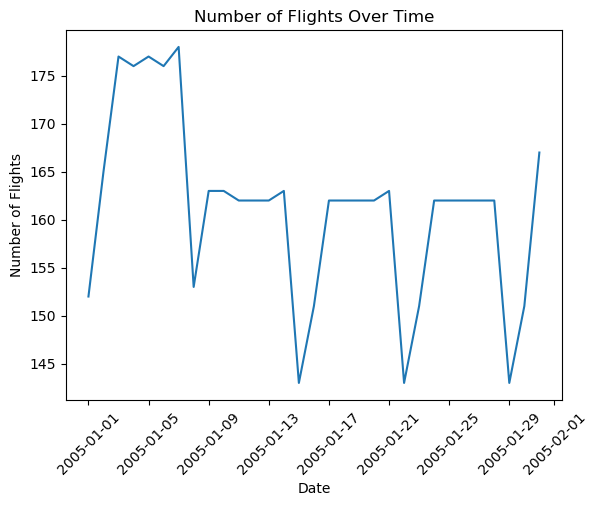

In [36]:
pandas_df['FlightDate'] = pd.to_datetime(pandas_df['FlightDate'])

flight_counts = pandas_df.groupby('FlightDate').size()

plt.plot(flight_counts.index, flight_counts.values)

plt.xlabel('Date')
plt.ylabel('Number of Flights')
plt.title('Number of Flights Over Time')
plt.xticks(rotation=45)
plt.show()

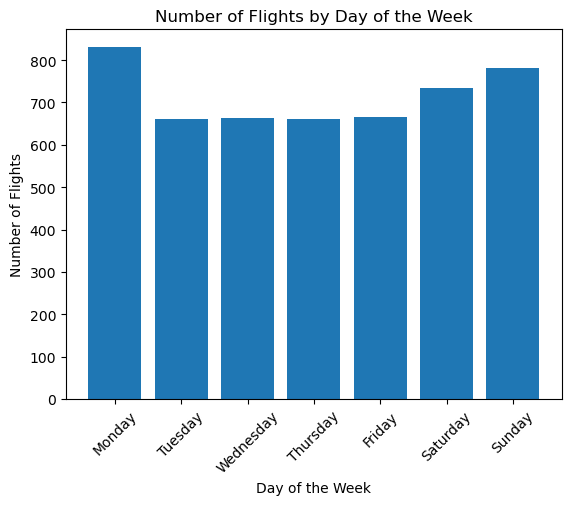

In [41]:
df_day_of_week = pd.DataFrame(flights_count.collect(), columns=['DayOfWeek', 'FlightCount'])

df_day_of_week = df_day_of_week.drop(index=5)

df_day_of_week['DayOfWeek'] = df_day_of_week['DayOfWeek'].astype(int)

df_day_of_week.sort_values('DayOfWeek', inplace=True)

days = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
df_day_of_week['DayOfWeek'] = df_day_of_week['DayOfWeek'].map(days)

plt.bar(df_day_of_week['DayOfWeek'], df_day_of_week['FlightCount'])

plt.xticks(rotation=45)

plt.xlabel('Day of the Week')
plt.ylabel('Number of Flights')
plt.title('Number of Flights by Day of the Week')
plt.show()

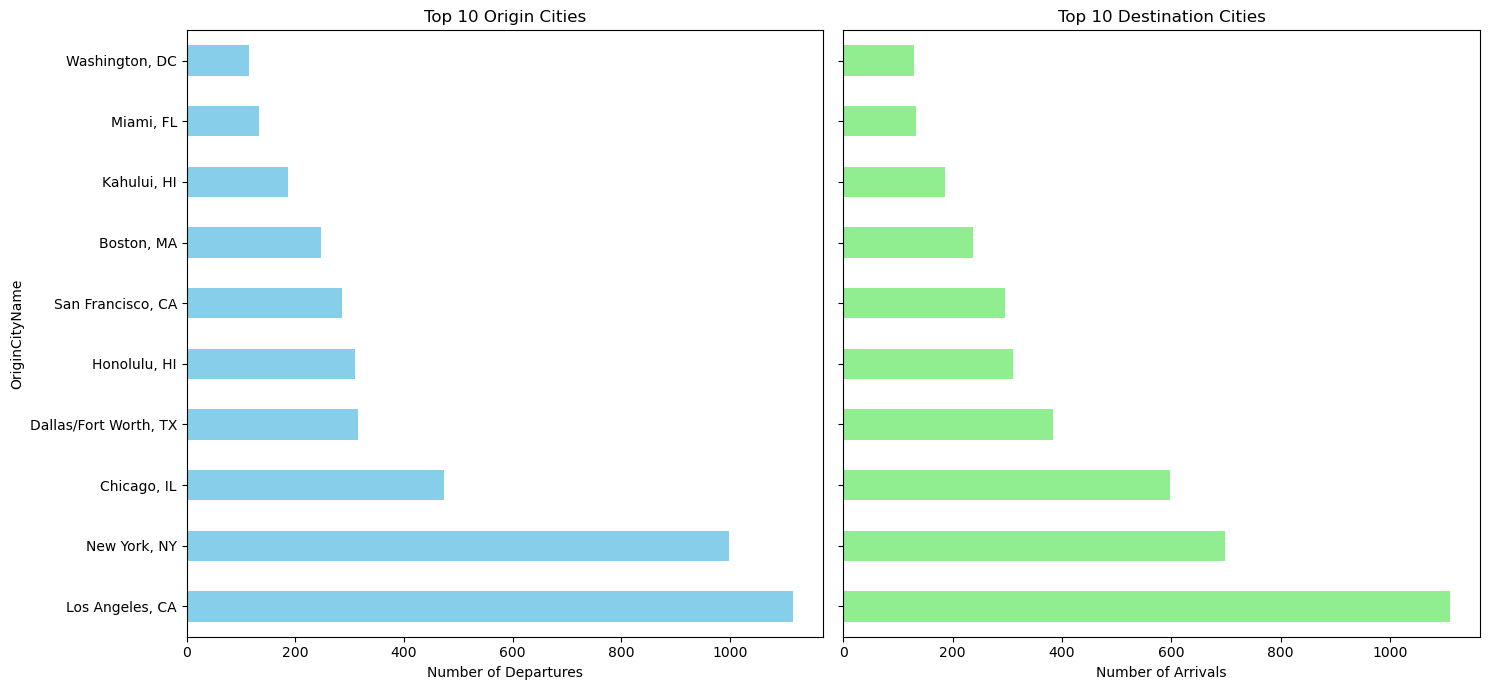

In [51]:
origin_counts = pandas_df['OriginCityName'].value_counts().nlargest(10)

dest_counts = pandas_df['DestCityName'].value_counts().nlargest(10)

fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

origin_counts.plot(kind='barh', ax=ax[0], color='skyblue')
ax[0].set_title('Top 10 Origin Cities')
ax[0].set_xlabel('Number of Departures')

dest_counts.plot(kind='barh', ax=ax[1], color='lightgreen')
ax[1].set_title('Top 10 Destination Cities')
ax[1].set_xlabel('Number of Arrivals')

plt.tight_layout()
plt.show()

In [61]:
popular_routes = (
    subset_rdd
    .map(lambda x: ((x[0], x[15], x[24]), 1))  # map to ((Year, Origin, Dest), 1)
    .reduceByKey(lambda a, b: a + b)  # reduce by key to count routes
    .map(lambda x: (x[0][0], (x[0][1], x[0][2], x[1])))  # map to (Year, (Origin, Dest, Count))
    .groupByKey()  # group by Year
    .mapValues(lambda x: sorted(x, key=lambda y: y[2], reverse=True))  # sort by Count within each Year
)
print(popular_routes.collect())

# we see that in 2005, the route with the most flights is from new york to chicago
# followed by new york to los angeles which was tied with los angeles to new york

[('2005', [('New York, NY', 'Chicago, IL', 422), ('New York, NY', 'Los Angeles, CA', 317), ('Los Angeles, CA', 'New York, NY', 317), ('New York, NY', 'San Francisco, CA', 145), ('San Francisco, CA', 'New York, NY', 145), ('Los Angeles, CA', 'Boston, MA', 131), ('Boston, MA', 'Los Angeles, CA', 131), ('Los Angeles, CA', 'Honolulu, HI', 124), ('Los Angeles, CA', 'Miami, FL', 124), ('Miami, FL', 'Los Angeles, CA', 124), ('Honolulu, HI', 'Los Angeles, CA', 124), ('Chicago, IL', 'New York, NY', 122), ('Newark, NJ', 'Los Angeles, CA', 93), ('Los Angeles, CA', 'Washington, DC', 93), ('Washington, DC', 'Los Angeles, CA', 93), ('Los Angeles, CA', 'Newark, NJ', 93), ('Honolulu, HI', 'Dallas/Fort Worth, TX', 62), ('Chicago, IL', 'Honolulu, HI', 62), ('Kahului, HI', 'Los Angeles, CA', 62), ('Los Angeles, CA', 'Kahului, HI', 62), ('Dallas/Fort Worth, TX', 'Tampa, FL', 62), ('Dallas/Fort Worth, TX', 'Honolulu, HI', 62), ('Honolulu, HI', 'Chicago, IL', 62), ('New York, NY', 'San Diego, CA', 57), ('Sa

In [ ]:
flight_durations = (
    subset_rdd
    .filter(lambda x: x[50])  # filter out records where AirTime is None or empty
    .map(lambda x: (x[0], (float(x[50]), 1)))  # map to (Year, (AirTime, 1))
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))  # sum AirTime and count
    .mapValues(lambda x: x[0] / x[1])  # calculate average AirTime
    .sortByKey()  # sort by Year
)
print(flight_durations.collect())

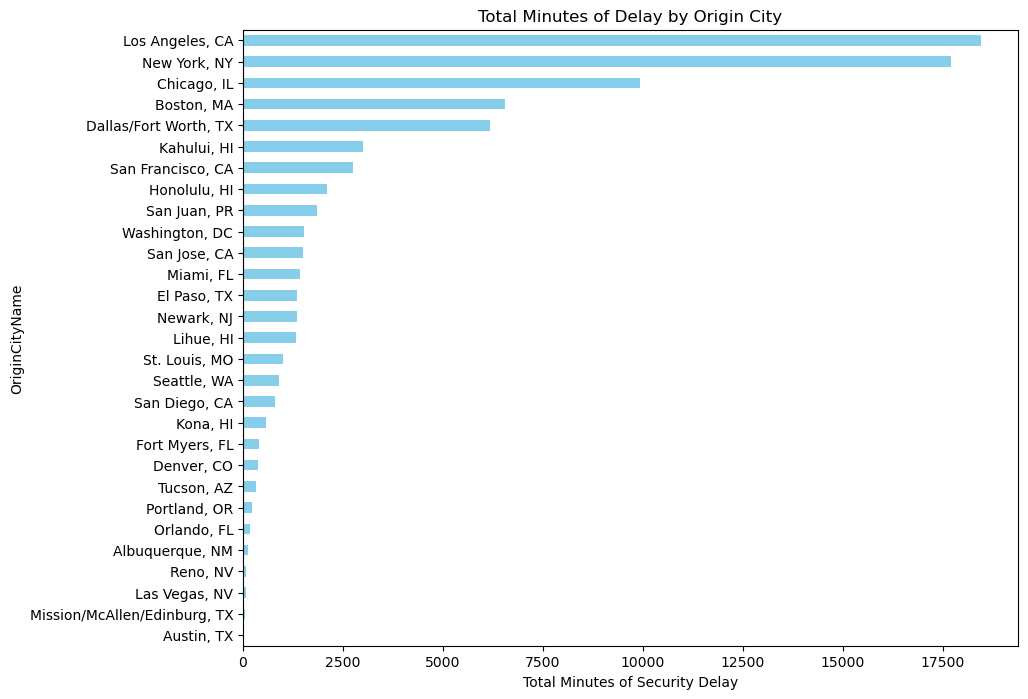

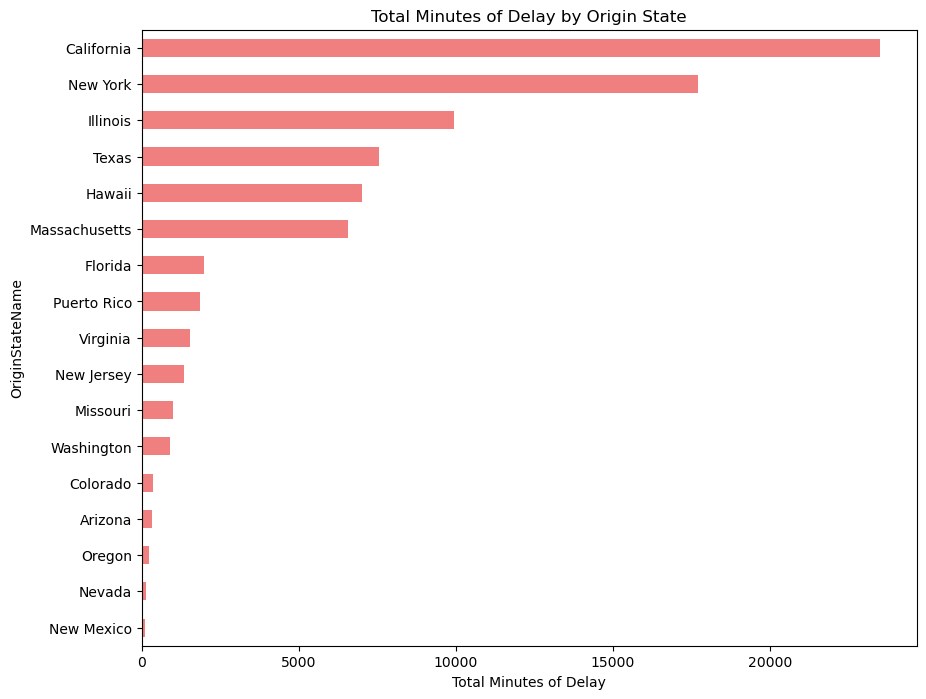

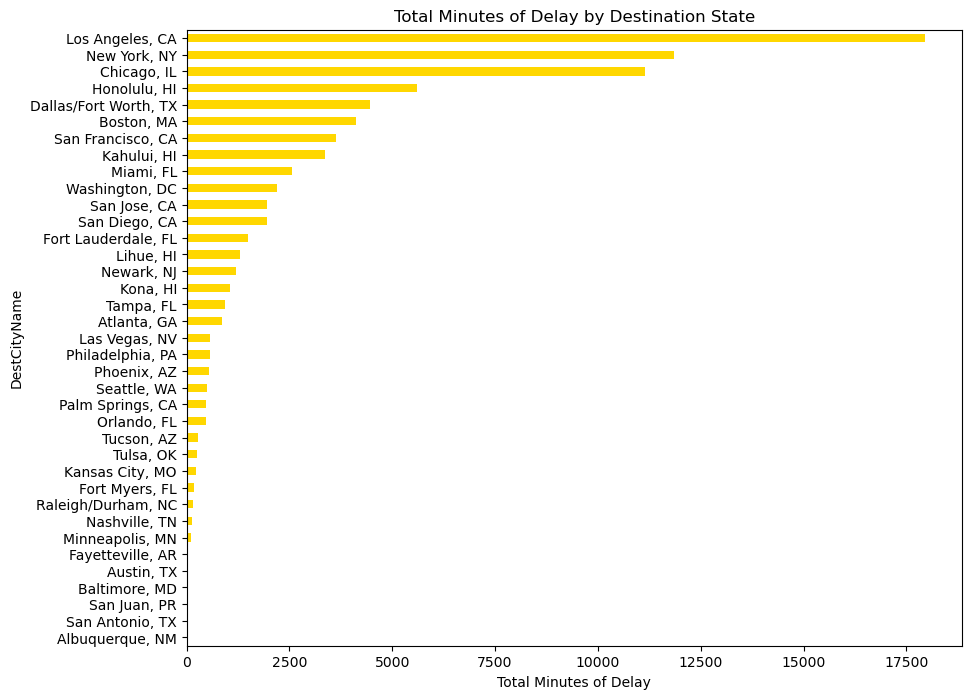

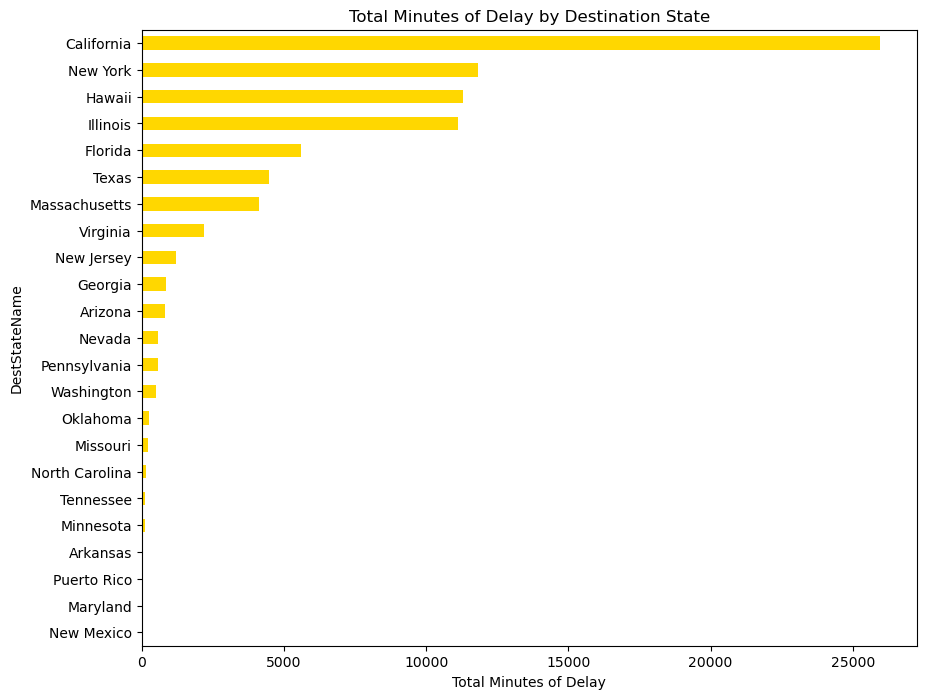

In [116]:
# Clean 'DepDelayMinutes' column by replacing empty strings with NaN and converting to float
pandas_df['DepDelayMinutes'] = pd.to_numeric(pandas_df['DepDelayMinutes'], errors='coerce')
pandas_df['ArrDelayMinutes'] = pd.to_numeric(pandas_df['ArrDelayMinutes'], errors='coerce')


# 1. Group by 'OriginCityName' and plot total minutes of delay
grouped_city = pandas_df.groupby('OriginCityName')['DepDelayMinutes'].sum().sort_values()
grouped_city.plot(kind='barh', figsize=(10, 8), color='skyblue')
plt.xlabel('Total Minutes of Security Delay')
plt.title('Total Minutes of Delay by Origin City')
plt.show()

# 2. Group by 'OriginStateName' and plot total minutes of delay
grouped_state = pandas_df.groupby('OriginStateName')['DepDelayMinutes'].sum().sort_values()
grouped_state.plot(kind='barh', figsize=(10, 8), color='lightcoral')
plt.xlabel('Total Minutes of Delay')
plt.title('Total Minutes of Delay by Origin State')
plt.show()

# 3. Group by 'DestCityName' and plot total minutes of carrier delay
grouped_carrier = pandas_df.groupby('DestCityName')['ArrDelayMinutes'].sum().sort_values()
grouped_carrier.plot(kind='barh', figsize=(10, 8), color='gold')
plt.xlabel('Total Minutes of Delay')
plt.title('Total Minutes of Delay by Destination State')
plt.show()

# 3. Group by 'DestStateName' and plot total minutes of carrier delay
grouped_carrier = pandas_df.groupby('DestStateName')['ArrDelayMinutes'].sum().sort_values()
grouped_carrier.plot(kind='barh', figsize=(10, 8), color='gold')
plt.xlabel('Total Minutes of Delay')
plt.title('Total Minutes of Delay by Destination State')
plt.show()
